* 将 'Monarch [no longer operating]'(放入到dev中) 替换为 'LAN Airlines (now LATAM Airlines)' 主要去预测 'WOW air [no longer operating]'

In [5]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import gzip
import os
import warnings
import random
import graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from bayes_opt import BayesianOptimization
from graphviz import Digraph

%matplotlib inline

In [16]:
df = pd.read_csv("./merge_result.csv")
print(df.info())
df = df.loc[df['is_defunct'].notnull()]

test_company = ['Primera Air [no longer operating]', 'WOW air [no longer operating]', 'LAN Airlines (now LATAM Airlines)', 'Air France', 'Virgin Australia', 'Viva Aerobus', 'Central Mountain Air', 'Juneyao Airlines', 'Ural Airlines', 'Corendon Airlines', 'Jeju Air', 'Royal Air Maroc', 'Vanilla Air', 'Kuwait Airways', 'Philippine Airlines (PAL)', 'TAME Vuela Ecuador', 'Pobeda', 'SmartWings', 'Thomas Cook Airlines Scandinavia', 'Ukraine International Airlines', 'Cayman Airways', 'Croatia Airlines', 'Kulula', 'Beijing Capital Airlines', 'China Eastern Airlines', 'QAZAQ AIR', 'Jetstar Japan',  'Silver Airways', 'Tajik Air', 'Boliviana de Aviacion', 'Mauritania Airlines', 'Myanmar National Airlines', 'AirAsia - Philippines AirAsia', 'Interjet', 'Myanmar Airways International', 'Wamos Air', 'Andes Lineas Aereas', 'Air Panama', 'TUIfly (Germany)', 'Royal Jordanian', 'Lufthansa', 'Norwegian', 'Virgin Atlantic Airways', 'Mann Yadanarpon Airlines', 'Kan Airlines', 'Sudan Airways', 'Viva Air (Colombia)', 'Biman Bangladesh Airlines', 'China Southern Airlines', 'Flynas', 'SriLankan Airlines', 'Sun Country Airlines', 'Nordica', 'AnadoluJet', 'Thai Lion Air', 'Flyadeal', 'Jin Air', 'tigerair australia', 'Air Madagascar', 'Southwest Airlines', 'Nouvel Air Tunise', 'TAROM', 'Wings Air', 'British Airways']
test = df[df['companyName'].isin(test_company)]
train = df[~df['companyName'].isin(test_company)]
y_train = train['is_defunct']
X_train = train.drop(columns=['is_defunct'])
y_test = test['is_defunct']
X_test = test.drop(columns=['is_defunct'])

features = list(X_train.columns)
del_cols = ['companyName', 'DOW', 'country_code', 'busn_name', 'cust_id_concatenate', 'airline_tagging', 'country', 'max_accident_date']
for col in del_cols:
    features.remove(col)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21541 entries, 0 to 21540
Columns: 176 entries, companyName to entertainment_rp
dtypes: float64(167), int64(1), object(8)
memory usage: 28.9+ MB
None


In [17]:
param = { #修改过的
    "boosting": "gbdt",
    'objective':'binary',
    'scale_pos_weight': 15,
    'metric': ('auc', 'binary_logloss'),
#     'metric': 'binary_logloss',
    'learning_rate': 0.001,
    'num_leaves': 6, # 6
    'min_data_in_leaf': 200, #120
    'max_depth': 5,                        
    "feature_fraction": 0.60279441778009675,
    "bagging_freq": 1,  #int(bagging_freq),   #1
    "bagging_fraction": 0.94918097174380245 ,
    "bagging_seed": 11,
    "lambda_l1": 3.0031581969835157,
    "verbosity": -1,        
}

In [18]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
evals_result = {}  #记录训练结果所用

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx])
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx])

    num_round = 20000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    evals_result=evals_result,   #非常重要的参数,一定要明确设置
                    verbose_eval=500,
                    early_stopping_rounds=200
    )
    
    oof[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(X_test[features], num_iteration=clf.best_iteration) / folds.n_splits

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[230]	training's auc: 0.999609	training's binary_logloss: 0.161608	valid_1's auc: 0.999477	valid_1's binary_logloss: 0.157629
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[217]	training's auc: 0.999186	training's binary_logloss: 0.162319	valid_1's auc: 0.999353	valid_1's binary_logloss: 0.16807
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[63]	training's auc: 0.999073	training's binary_logloss: 0.195963	valid_1's auc: 0.9993	valid_1's binary_logloss: 0.195306
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[228]	training's auc: 0.999104	training's binary_logloss: 0.164125	valid_1's auc: 0.999067	valid_1's binary_logloss: 0.157568
fold n°4
Training until validation scores don't improve for 200 rounds.


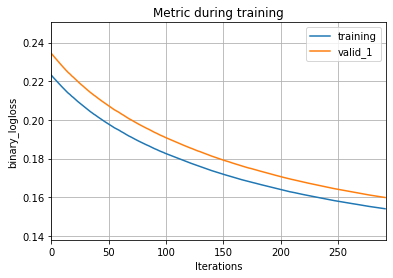

In [19]:
lgb.plot_metric(evals_result, metric='binary_logloss')#metric的值与之前的params里面的值对应

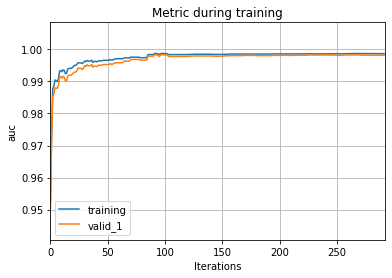

In [20]:
lgb.plot_metric(evals_result, metric='auc')#metric的值与之前的params里面的值对应

[1.23640731 0.23640731 0.23584469 ... 0.04771628 0.04771374 0.04766806]


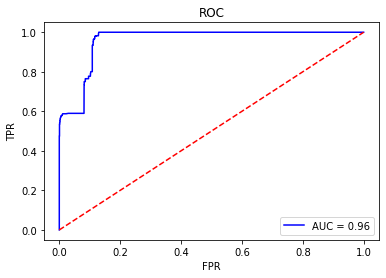

In [21]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def draw_ROC_curve(y_test,y_predict,savepath=None):
    '''
    画ROC曲线
    '''
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    print(thresholds)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    if savepath:
        plt.savefig(savepath)
    plt.close(0)

draw_ROC_curve(y_train, oof)

[1.14749371 0.14749371 0.13708768 0.13705708 0.1280189  0.12789746
 0.12775188 0.12758146 0.12629836 0.12400329 0.12262272 0.12213541
 0.1215272  0.12101533 0.1207838  0.12071602 0.11947885 0.11935668
 0.11869388 0.11846986 0.11617219 0.11512407 0.11464063 0.10380165
 0.10373159 0.1013315  0.10117246 0.10106141 0.09935674 0.07979415
 0.07975836 0.07931164 0.07804063 0.07795746 0.07772929 0.07762554
 0.07708802 0.07688446 0.07666397 0.07449752 0.07441918 0.07398581
 0.06880875 0.06733858 0.0649003  0.06297423 0.0625386  0.0622549
 0.06213854 0.06207516 0.06188047 0.06161149 0.06129227 0.06062092
 0.06024691 0.06013582 0.0600647  0.06003319 0.06001465 0.05992266
 0.05975689 0.05959097 0.0595298  0.05952358 0.0594732  0.05941701
 0.05927895 0.05926644 0.05921871 0.05915779 0.0591391  0.05896454
 0.05890523 0.05882047 0.05857483 0.05845865 0.05832957 0.05819383
 0.05819356 0.05797677 0.05793928 0.05793732 0.05789231 0.05774884
 0.05759342 0.05724699 0.05694282 0.05689197 0.05678635 0.05678

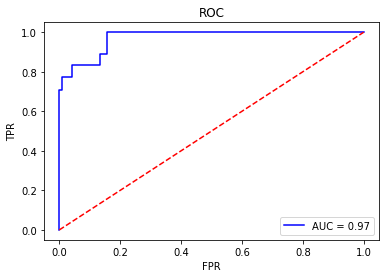

In [22]:
draw_ROC_curve(y_test, predictions)

In [33]:
new_test = pd.concat([test[['companyName', 'DOW']].reset_index(), pd.Series(predictions, name='pred')], axis=1)
new_test_company = ['Primera Air [no longer operating]', 'LAN Airlines (now LATAM Airlines)', 'WOW air [no longer operating]']
new_test = new_test[new_test['companyName'].isin(new_test_company)]

display(new_test.sort_values(['companyName', 'pred'], ascending=False))
new_test.sort_values(['companyName', 'pred'], ascending=False).to_csv('./score_rank.csv')
# display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']))

,index,companyName,DOW,pred
3394,20348,WOW air [no longer operating],2018-07,0.147494
3395,20349,WOW air [no longer operating],2018-08,0.147494
3396,20350,WOW air [no longer operating],2018-09,0.147494
3397,20351,WOW air [no longer operating],2018-10,0.147494
3398,20352,WOW air [no longer operating],2018-11,0.147494
3399,20353,WOW air [no longer operating],2018-12,0.147494
3400,20354,WOW air [no longer operating],2019-01,0.147494
3401,20355,WOW air [no longer operating],2019-02,0.147494
3402,20356,WOW air [no longer operating],2019-03,0.147494
3405,20359,WOW air [no longer operating],2012-10,0.147494


In [24]:
new_test = pd.concat([test['companyName'].reset_index(), pd.Series(predictions, name='pred')], axis=1)

display(new_test.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

,mean,min,max
companyName,,,
WOW air [no longer operating],0.147332,0.137088,0.147494
Mauritania Airlines,0.132319,0.127581,0.137057
LAN Airlines (now LATAM Airlines),0.125941,0.118470,0.128019
Kuwait Airways,0.120572,0.114641,0.120716
Kan Airlines,0.120503,0.119479,0.121527
Cayman Airways,0.120375,0.116172,0.124003
Air Panama,0.115124,0.115124,0.115124
Philippine Airlines (PAL),0.103732,0.103732,0.103732
Myanmar National Airlines,0.100006,0.099357,0.103802


In [37]:
new_train = pd.concat([train[['companyName', 'DOW']].reset_index(), pd.Series(oof, name='pred')], axis=1)
# new_train_company = ['Monarch [no longer operating]']
# new_train = new_train[new_train['companyName'].isin(new_train_company)]

display(new_train.sort_values('pred', ascending=False))
new_train.sort_values('pred', ascending=False).to_csv('./train_score_rank.csv')
# display(new_train.groupby('companyName')['pred'].agg(['mean', 'min', 'max']).sort_values('mean', ascending=False))

,index,companyName,DOW,pred
1284,1514,Air New Zealand,2018-12,0.236407
7612,9329,Icelandair,2016-12,0.236407
3009,3653,Avianca,2017-03,0.236407
7526,9243,Icelandair,2013-06,0.236407
7616,9333,Icelandair,2017-11,0.236407
3010,3654,Avianca,2017-04,0.236407
15942,21515,NaN,2011-12,0.236407
3015,3659,Avianca,2010-05,0.236407
15899,21472,NaN,2013-06,0.236407
3020,3664,Avianca,2010-12,0.236407
